# Data Pre-Processing Demo

The code file `data_prep.py` contains a series of modules to pre-process (e.g., merging, cleaning and preliminary plotting) the original datasets from different data sources. In this demo notebook, we call a series of functions and draw some plots to present the data pre-processing work.

### Original Data Sources
- **Accident (acc)** – Traffic Accident records contained in the HSIS (Highway Safety Information System) database
- **Curvature (curv)** – Roadway curvature information contained in the HSIS database
- **Grade (grad)** – Roadway grade information contained in the HSIS database
- **Road Segment (road)** – Roadway segment information (e.g., roadway inventory, milepost numbers, roadway geometry, etc.) contained in the HSIS database
- **Elevation (elev)** – Freeway elevation database created by research group in a previous research project

### Key Points in Data Merging
- Road segment is used as the base table for data merging, while accident, elevation, grade, and curvature data have been aggregated (e.g., count, average, maximum, and minimum) into the final dataset based on roadway inventory and milepost information.
- Two data sources (i.e., `elev` and `grad`) can provide roadway grade information. The elevation dataset has high resolution roadway elevation information (per 10ft) which is useful in producing grade statistics such as average, maximum and minimum, but only covers the Interstate freeway network. The HSIS grade dataset, although covering more roadway mileage, contains less-detailed grade information. Thus, the HSIS grade data is only applied when the elevation data for the road segment is not available.
- HSIS has different data tables for each analysis year. The data merging process first aggregates the annual data table for each year and then creates a final dataset combining all of the annual data tables.

### Basic Imports and Settings
Import the data pre-processing modules as well as required packages and settings for this demo.

In [1]:
import plotly.plotly as py
from data_prep import *

py.sign_in('charleyjoo', 'rx9n91vitl')

%matplotlib inline
plt.ioff()

C:\Miniconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.



### Explore the Database
Although the original datasets are given as `.csv` files, all the data have been read and converted into database tables to work with SQL query statements. The `sqlite3` package is applied to increase the efficiency in merging different data tables.

Swich the working directory to the data folder and set up a database connection.

In [2]:
set_directory()
conn = dbi.connect('crash_database')

Show the names of all tables in the database.
The four different datasets are stored in the database in the process of merging data. Data tables of different analysis years are also stored in the database. The `crash_data` is the final dataset that combines all six years of data.

In [3]:
get_tables(conn)

,name
0,data_06
1,data_07
2,data_09
3,data_10
4,data_11
5,road
6,acc
7,curv
8,grad
9,elev


In [4]:
conn.close()

Get the crash data table as a dataframe and show the first five rows.

In [5]:
crash_data = get_data()
crash_data.head()

,lshl_typ,med_type,rshl_typ,surf_typ,road_inv,spd_limt,begmp,endmp,lanewid,no_lanes,...,aadt_08,acc_ct_08,aadt_09,acc_ct_09,aadt_10,acc_ct_10,aadt_11,acc_ct_11,avg_aadt,tot_acc_ct
0,None,None,None,None,002,30.0,0.00,0.04,40,1,...,9361.0,0.0,9545.0,0.0,6482.0,0.0,6447.0,1.0,8294.666667,4.0
1,None,None,None,None,002,30.0,0.04,0.11,20,2,...,9361.0,0.0,9545.0,0.0,6482.0,0.0,6447.0,0.0,8294.666667,1.0
2,None,None,None,None,002,30.0,0.11,0.13,20,2,...,12104.0,0.0,12342.0,0.0,9036.0,0.0,8987.0,0.0,10532.000000,1.0
3,C,O,C,A,002,55.0,0.13,0.14,27,4,...,23222.0,0.0,23679.0,1.0,22821.0,0.0,22698.0,0.0,20742.000000,1.0
4,C,O,C,A,002,55.0,0.14,0.16,23,4,...,23222.0,2.0,23679.0,3.0,22821.0,0.0,22698.0,2.0,20742.000000,11.0


### Interactive Plotting Funtion
Below shows the interactive plotting function for the final dataset. Users can select dependent variables (e.g., accident counts) and independent variables (e.g., roadway geometry, traffic control, and vechile counts) from two dropdown lists. A scatterplot showing the relationship of the two selected variables is presented below.

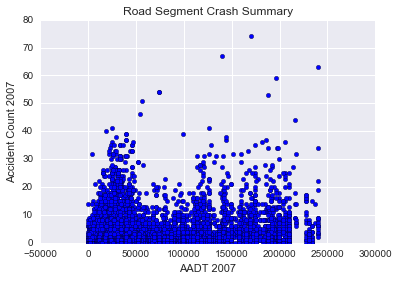

In [6]:
plot_x_vs_y()

### Interactive Plotting Funtion Using `plotly` Package

Below shows the interactive plotting function using the `plotly` package. The example figure shows the scatterplot of total accident count against the average AADT over the six years. The plotly figure enables detailed interactions with the data values as well as the figure setting (e.g., scale and axes of the figure). Users can put the mouse on scatterpoints to view the detailed value of the point.

In [7]:
fig = plot_scatter(x='Average AADT', y='Total Accident Count')
plt.xlim(xmin=0)
py.iplot_mpl(fig, strip_style = True, filename='ipython/mpl_example')

### SQL Query Example
Below is an example of the SQL code used in the merge_annual_data() function. The query statement basically get all the annual data tables in the database and merge them base on the roadway segment inventory and the mileposts.

```
    CREATE VIEW merge_data AS
    SELECT d.*,
           data_11.aadt AS aadt_11, data_11.acc_count AS acc_ct_11
    FROM (

    SELECT c.*,
           data_10.aadt AS aadt_10, data_10.acc_count AS acc_ct_10
    FROM (

    SELECT b.*,
           data_09.aadt AS aadt_09, data_09.acc_count AS acc_ct_09
    FROM (

    SELECT a.*,
           data_08.aadt AS aadt_08, data_08.acc_count AS acc_ct_08
    FROM (

    SELECT data_06.*,
           data_06.aadt AS aadt_06, data_06.acc_count AS acc_ct_06,
           data_07.aadt AS aadt_07, data_07.acc_count AS acc_ct_07
    FROM data_06

    LEFT JOIN data_07
    ON data_06.road_inv = data_07.road_inv AND
       data_06.begmp = data_07.begmp AND
       data_06.endmp = data_07.endmp
    ) AS a

    LEFT JOIN data_08
    ON a.road_inv = data_08.road_inv AND
       a.begmp = data_08.begmp AND
       a.endmp = data_08.endmp
    ) AS b

    LEFT JOIN data_09
    ON b.road_inv = data_09.road_inv AND
       b.begmp = data_09.begmp AND
       b.endmp = data_09.endmp
    ) AS c

    LEFT JOIN data_10
    ON c.road_inv = data_10.road_inv AND
       c.begmp = data_10.begmp AND
       c.endmp = data_10.endmp
    ) AS d

    LEFT JOIN data_11
    ON d.road_inv = data_11.road_inv AND
       d.begmp = data_11.begmp AND
       d.endmp = data_11.endmp
```